In [1]:
import torch
import torch.distributions as td
import torch.optim as opt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
plt.rcParams['figure.figsize'] = [14, 8]

In this notebook I'll try to perform numerical variational bayesian analysis that previously I've done with **Pyro** package.

In [3]:
# In the meantime I'll define thin wrappers around the probability distributions
class Bernoulli:
    def __init__(self, p):
        self.p = p
    
    def sample(self, size=1):
        return stats.bernoulli.rvs(p=self.p, size=size)
        
class Uniform:
    def __init__(self, start, end):
        self.start = start
        self.end = end
    
    def sample(self, size=1):
        return stats.uniform.rvs(loc=self.start, scale=self.end-self.start, size=size)
    
    def pdf(self, x):
        return stats.uniform.pdf(x, loc=self.start, scale=self.end-self.start)
    
    def mean(self):
        return stats.uniform.mean(loc=self.start, scale=self.end-self.start)
        
class Beta:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    def pdf(self, X):
        return stats.beta.pdf(X, a=self.alpha, b=self.beta)
    
    def mean(self):
        return stats.beta.mean(a=self.alpha, b=self.beta)
    
    
class Normal:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, X):
        return stats.norm.pdf(X, loc=self.mu, scale=self.sigma)
    
    def sample(self, size=1):
        return stats.norm.rvs(loc=self.mu, scale=self.sigma, size=size)
    
    def mean(self):
        return self.mu

In this example we have:
- Prior $\mathbb{P}(\theta) \sim N(0, 1)$
- Likelihood $\mathbb{P}(X | \theta) \sim N(\theta, 1)$

In [4]:
N = 100

In [5]:
Prior = Normal(0, 1)

In [6]:
hidden_theta = Prior.sample()[0]
print("theta=", hidden_theta)
Likelihood = Normal(hidden_theta, 1)
X = Likelihood.sample(N)

theta= 1.1854191470066868


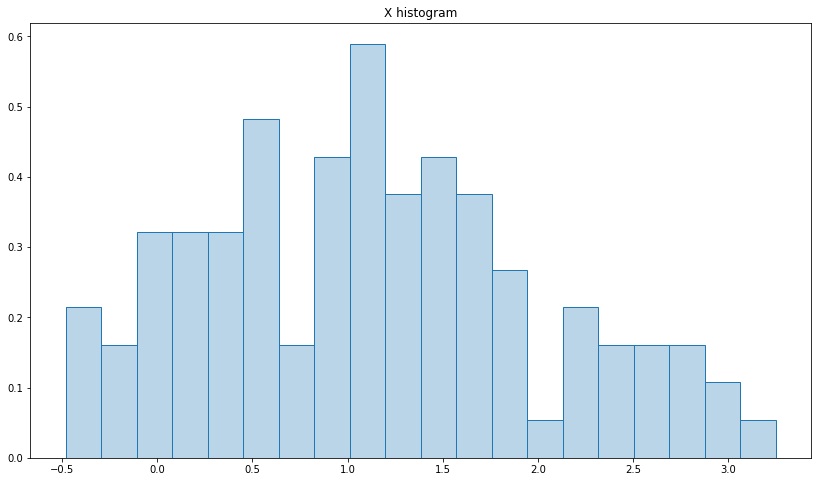

In [7]:
fig, axs = plt.subplots(1, 1)
axs.set_title("X histogram")
color = next(axs._get_lines.prop_cycler)["color"]
axs.hist(X, bins=20, density=True, color=color, alpha=0.3)
axs.hist(X, bins=20, density=True, color=color, edgecolor=color, fc="None", lw=1)
None

In [8]:
TruePosterior = Normal(X.sum() / (X.size + 1), 1.0 / np.sqrt(X.size + 1))

In [9]:
# Data as PyTorch tensor
TX = torch.from_numpy(X).to(torch.float64)

In [10]:
mu = torch.tensor(2.0, dtype=torch.float64, requires_grad=True)
std = torch.tensor(4.0, dtype=torch.float64, requires_grad=True)

In [11]:
# Prior model defined using PyTorch distributions
TPrior = td.Normal(0, 1)

In [12]:
def calculate_elbo():
    # Our variational distribution
    q_distribution = td.Normal(mu, std.clamp(0.0))
    # All samples are calculated with respect to q distribution, therefore we sample from q
    theta_sample = q_distribution.rsample()

    # First bit, model log prob assuming theta is the hidden param
    log_prob_theta_model = TPrior.log_prob(theta_sample)
    #print("lptm=", log_prob_theta_model)
    log_prob_data_model = td.Normal(theta_sample, 1).log_prob(TX).sum()
    #print("lpdm=", log_prob_data_model)

    # Second bit, variational distribution log prob, assuming theta is the hidden param
    log_prob_q = q_distribution.log_prob(theta_sample)
    
    #print("lpq=", log_prob_q)
    
    return log_prob_theta_model + log_prob_data_model - log_prob_q

In [13]:
OPTIMIZATION_STEPS = 10_000

In [14]:
optimizer = opt.Adam([mu, std], lr=0.01)

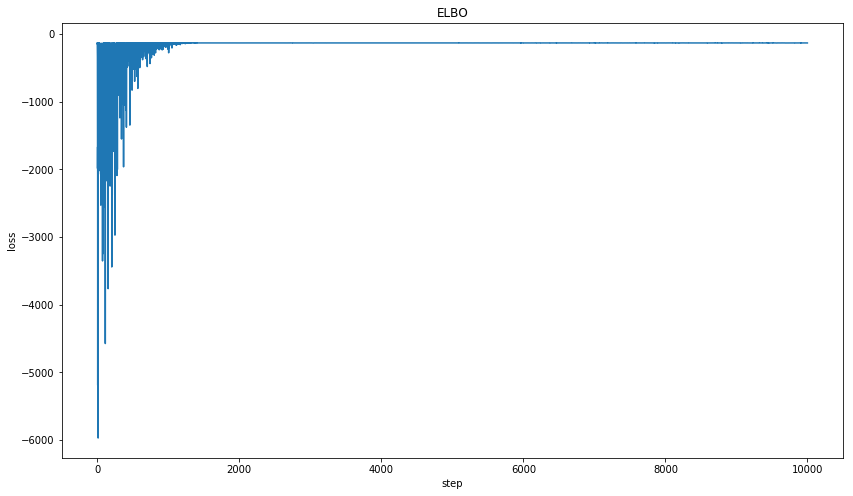

In [15]:
# metrics
elbo_history = []
mu_history = []
std_history = []

for i in range(OPTIMIZATION_STEPS):
    optimizer.zero_grad()
    
    elbo = calculate_elbo()
    loss = -elbo
    loss.backward()
    
    elbo_history.append(elbo.item())
    mu_history.append(mu.item())
    std_history.append(std.item())
    
    optimizer.step()
    
plt.plot(elbo_history)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
None

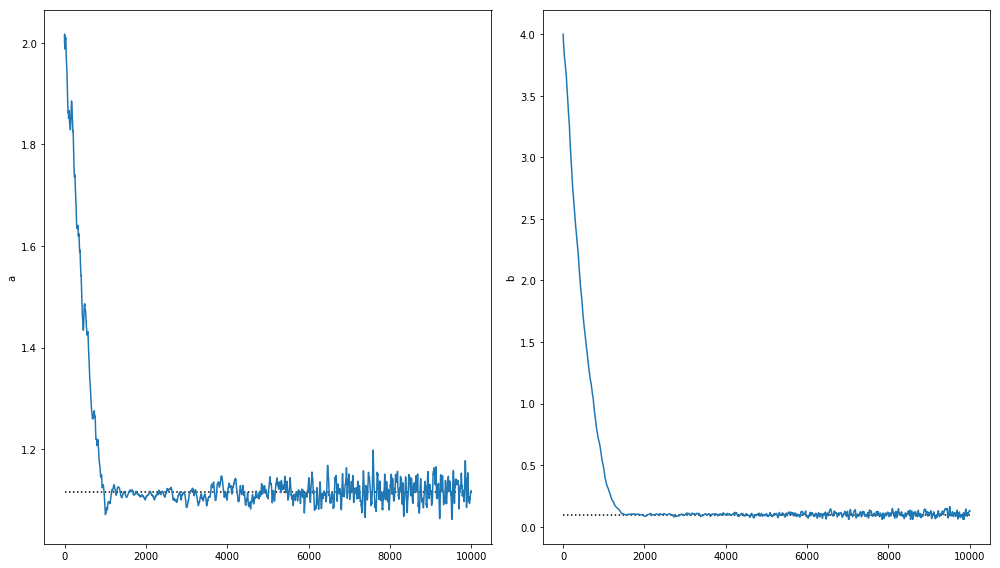

In [16]:
plt.subplot(1,2,1)
plt.plot([0,OPTIMIZATION_STEPS],[X.sum() / (X.size + 1), X.sum() / (X.size + 1)], 'k:')
plt.plot(mu_history)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,OPTIMIZATION_STEPS],[1.0 / np.sqrt(X.size + 1), 1.0 / np.sqrt(X.size + 1)], 'k:')
plt.plot(std_history)
plt.tight_layout()

In [17]:
hidden_theta

1.1854191470066868

In [18]:
MU = mu.item()
STD = std.item()
print("MU=", MU)
print("STD=", STD)

MU= 1.1122417854101698
STD= 0.12548676532719782


In [19]:
EstimatedPosterior = Normal(MU, STD)

In [20]:
MLE = MU

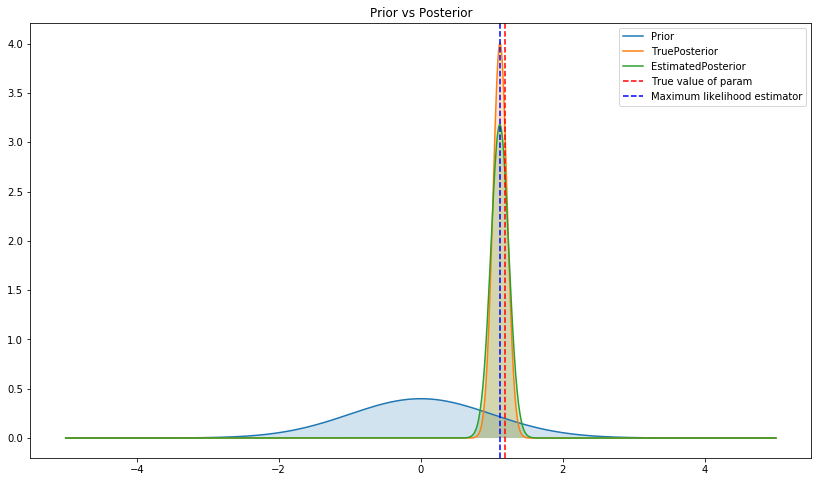

In [21]:
fig, axs = plt.subplots(1, 1)
axs.set_title("Prior vs Posterior")
support = np.linspace(-5.0, 5.0, 1000)

axs.plot(support, Prior.pdf(support), label="Prior")
axs.fill_between(support, 0, Prior.pdf(support), alpha=0.2)
axs.plot(support, TruePosterior.pdf(support), label="TruePosterior")
axs.fill_between(support, 0, TruePosterior.pdf(support), alpha=0.2)
axs.plot(support, EstimatedPosterior.pdf(support), label="EstimatedPosterior")
axs.fill_between(support, 0, EstimatedPosterior.pdf(support), alpha=0.2)
axs.axvline(hidden_theta, color='red', linestyle='--', label='True value of param')
axs.axvline(MLE, color='blue', linestyle='--', label='Maximum likelihood estimator')


axs.legend()